In [1]:
#rebuild tensorflow with comiler flags
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import necessary libraries and packages
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from tensorflow.python.keras.metrics import Metric
from itertools import product
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from statsmodels.tsa.stattools import adfuller


import warnings

# Preferred settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [2]:
#Import Footprint and Biocapacity data
data = pd.read_csv('../Data/footprint-nfba-2019/data/nfa_2019_public_data.csv')

#Observe data shape and head
print(data.shape)

(72186, 12)


In [3]:
data.dtypes

country            object
year                int64
country_code        int64
record             object
crop_land         float64
grazing_land      float64
forest_land        object
fishing_ground    float64
built_up_land     float64
carbon            float64
total             float64
qscore             object
dtype: object

In [4]:
#modify the datatype of country, record and QScore columns
data["country"] = data['country'].astype('string')
data["record"] = data['record'].astype('string')
data["qscore"] = data['qscore'].astype('string')

data.dtypes

country            string
year                int64
country_code        int64
record             string
crop_land         float64
grazing_land      float64
forest_land        object
fishing_ground    float64
built_up_land     float64
carbon            float64
total             float64
qscore             string
dtype: object

In [5]:
#drop null values
df = data.dropna(axis=0, thresh=7)
#compression_opts = dict(method='zip', archive_name='out.csv')  
#df.to_csv('out.zip', index=False, compression=compression_opts) 

print(df.shape)
print(df.isna().sum())

(51714, 12)
country           0
year              0
country_code      0
record            0
crop_land         0
grazing_land      0
forest_land       0
fishing_ground    1
built_up_land     1
carbon            1
total             1
qscore            1
dtype: int64


In [6]:
#Only include India's Ecological Footprint data 
df_India = df.loc[(df['country'] == "India") & (df['record'] == "EFConsPerCap") ,['year','total']]
df_India = df_India[['year', 'total']]
df_lstm = df_India
#observe shape of reformatted df
print(df_India.shape)

(56, 2)


In [7]:
#Convert year to index
df_India.set_index('year', inplace=True)

#Convert year to DateTime object
df_India.index = pd.to_datetime(df_India.index, format='%Y')

In [8]:
# Train-test split
x = df_India.index
y = df_India['total']

train = df_India.loc['1963-01-01':'2011-01-01']
test = df_India.loc['2011-01-01':]

x_train, x_test = train.index, test.index
y_train, y_test = train['total'], test['total']

In [9]:
#instatiate Holt-Winter's Model
model = ExponentialSmoothing(df_India.total,trend = 'add', seasonal = 'add', seasonal_periods=12)
fit = model.fit()
preds = fit.fittedvalues.shift(-1)

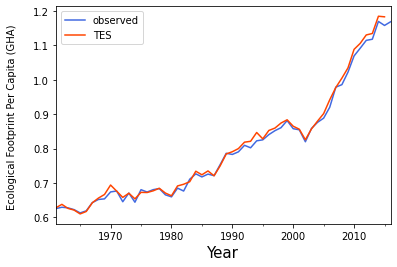

In [10]:
# observe the DES model against the original data
ax = df_India.total.plot(label='observed', color='royalblue', legend=True)
preds.plot(ax=ax, label='TES', color='orangered', legend=True )

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Ecological Footprint Per Capita (GHA) \n', size=10)
#ax.set_title('Real vs Predicted Ecological Footprint Per Capita \n', size=15)

plt.legend()
plt.show()

In [41]:
ES_Result =  pd.DataFrame(columns=['raw', 'predicted', 'residuals'])
ES_Result['raw'] = df_India.total
ES_Result['predicted'] = preds
ES_Result['residuals'] = ES_Result['raw'] - ES_Result['predicted']
ES_Result = ES_Result.dropna(how='any')

In [43]:
ES_Result['residuals'].describe()

count    55.000000
mean     -0.007078
std       0.008328
min      -0.025083
25%      -0.012978
50%      -0.006326
75%       0.000443
max       0.007806
Name: residuals, dtype: float64

### Hybrid LSTM-ES Model

In [44]:
residual_es = pd.DataFrame(ES_Result['residuals'])
residual_es

,residuals
year,
1961-01-01,-0.002389
1962-01-01,-0.008376
1963-01-01,0.001518
1964-01-01,0.001319
1965-01-01,0.002944
1966-01-01,0.001860
1967-01-01,0.000396
1968-01-01,-0.003985
1969-01-01,-0.012730


<AxesSubplot:xlabel='year'>

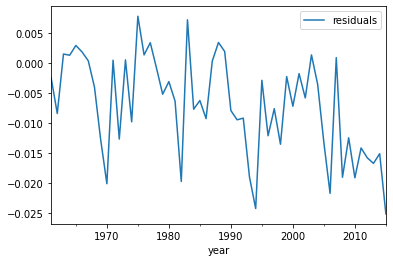

In [45]:
residual_es.plot()

<AxesSubplot:ylabel='Density'>

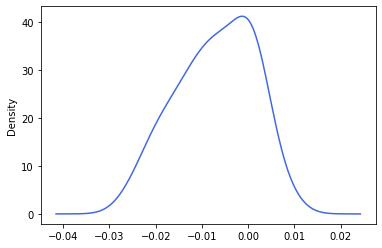

In [46]:
ES_Result['residuals'].plot(kind='kde', color='royalblue')

#### Model

In [47]:
#fix random seed for reproducibility
np.random.seed(42)

In [48]:
data = residual_es['residuals']
dataset = residual_es.values
dataset = dataset.astype('float32')
dataset.shape

(55, 1)

In [49]:
#normalize
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset) 
scaled_dataset.shape

(55, 1)

In [50]:
#split train-set
train_size = int(len(scaled_dataset)*0.90)
test_size = len(scaled_dataset) - train_size
train, test = scaled_dataset[0:train_size,:], scaled_dataset[train_size:len(scaled_dataset),:]
print(len(train), len(test))

49 6


In [51]:
train.shape

(49, 1)

In [52]:
test.shape

(6, 1)

In [53]:
# Convert the data into a Supervised-learning data

x = []
y = []
look_back = 4
for i in range(look_back, len(train)):
    x.append(train[i-look_back:i, 0])
    y.append(train[i, 0])

# Converting into numpy sequences to train the LSTM model
trainX, trainY = np.array(x), np.array(y) 

In [54]:
# Reshape the training data to 3 dimensional for LSTM input.
X_train = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

In [55]:
X_train.shape

(45, 4, 1)

In [56]:
trainY.shape

(45,)

In [57]:
#create and fit the LSTM network
modelx = Sequential()

#Add first LSTM layer with 20% dropout regularisation
modelx.add(LSTM(units = 100,
                return_sequences = True,
                activation = 'relu',
                input_shape = (X_train.shape[1], 1)))
modelx.add(Dropout(0.3))

#Add Second LSTM Layer
modelx.add(LSTM(units = 90,
                return_sequences = True,
                activation = 'relu'))
modelx.add(Dropout(0.2))
#Add Third LSTM Layer
modelx.add(LSTM(units = 90,
                activation = 'relu'))
modelx.add(Dropout(0.2))

#Add output layer
modelx.add(Dense(1))

In [58]:
modelx.compile(loss='mean_squared_error', optimizer='adam')
history = modelx.fit(X_train,
                     trainY, 
                     epochs = 100, 
                     batch_size = 128, 
                     validation_split = 0.2, 
                     verbose = 1, 
                     shuffle = False)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.4069 - val_loss: 0.3108
Epoch 2/100
1/1 [==============================] - 0s 44ms/step - loss: 0.3972 - val_loss: 0.3028
Epoch 3/100
1/1 [==============================] - 0s 45ms/step - loss: 0.3877 - val_loss: 0.2942
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 0.3773 - val_loss: 0.2852
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 0.3662 - val_loss: 0.2754
Epoch 6/100
1/1 [==============================] - 0s 44ms/step - loss: 0.3542 - val_loss: 0.2648
Epoch 7/100
1/1 [==============================] - 0s 47ms/step - loss: 0.3416 - val_loss: 0.2533
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - loss: 0.3261 - val_loss: 0.2408
Epoch 9/100
1/1 [==============================] - 0s 47ms/step - loss: 0.3146 - val_loss: 0.2273
Epoch 10/100
1/1 [==============================] - 0s 42ms/step - loss: 0.2964 - val_loss: 0.2126
Epoch 11/100
1/1 [===

Epoch 84/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0587 - val_loss: 0.0621
Epoch 85/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0553 - val_loss: 0.0620
Epoch 86/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0526 - val_loss: 0.0621
Epoch 87/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0608 - val_loss: 0.0622
Epoch 88/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0659 - val_loss: 0.0623
Epoch 89/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0567 - val_loss: 0.0625
Epoch 90/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0555 - val_loss: 0.0627
Epoch 91/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0580 - val_loss: 0.0629
Epoch 92/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0532 - val_loss: 0.0631
Epoch 93/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0590 - val_loss: 0.0632
Epoch 94/1

In [59]:
#Construct Metircs for the LSTM Model
metrics = pd.DataFrame(modelx.history.history)
metrics.head()

,loss,val_loss
0,0.406929,0.310782
1,0.397157,0.302755
2,0.387691,0.294220
3,0.377261,0.285160
4,0.366194,0.275393


Text(0, 0.5, 'Loss')

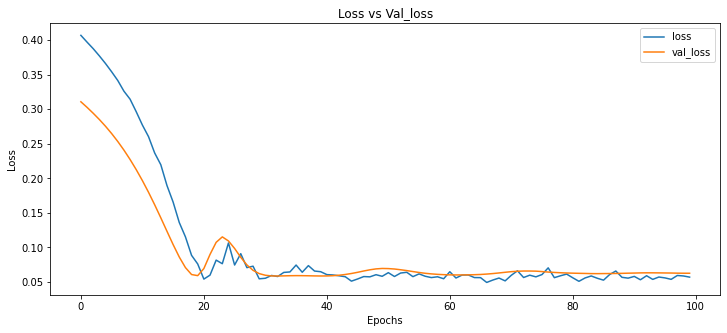

In [60]:
#Plot the loss of LSTM Model

metrics[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss vs Val_loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [61]:
# Prepare the test data for validation
test_data = scaled_dataset[train_size - look_back: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  dataset[train_size : , : ]
for i in range(look_back, len(test_data)):
    X_test.append(test_data[i-look_back:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

***Prediction***

In [62]:
#process data to avoid truncation
test = residual_es.head(4)
test = pd.concat([test, residual_es])
test.dropna()

,residuals
year,
1961-01-01,-0.002389
1962-01-01,-0.008376
1963-01-01,0.001518
1964-01-01,0.001319
1961-01-01,-0.002389
1962-01-01,-0.008376
1963-01-01,0.001518
1964-01-01,0.001319
1965-01-01,0.002944


In [63]:
test.reset_index(drop=True, inplace=True)
test

,residuals
0,-0.002389
1,-0.008376
2,0.001518
3,0.001319
4,-0.002389
5,-0.008376
6,0.001518
7,0.001319
8,0.002944
9,0.001860


In [64]:
#Normalize data 
target_test = test.iloc[:, 0:1].values
test_scaled = scaler.fit_transform(target_test)
test_scaled.shape

(59, 1)

In [65]:
test = test_scaled[:,:]

#convert data
xf_test = []
yf_test = dataset[: , :]

for i in range(look_back, len(test)):
    xf_test.append(test[i-look_back:i, 0])

#convert to a numpy array
xf_test = np.array(xf_test)

#reshape the data into dimensions of LSTM model
xf_test = xf_test.reshape(xf_test.shape[0], xf_test.shape[1], 1)
xf_test.shape

(55, 4, 1)

In [66]:
yf_test.shape

(55, 1)

In [67]:
#predictions of entire dataset using LSTM Model
predicted_resid = modelx.predict(xf_test)
predicted_resid = scaler.inverse_transform(predicted_resid)
predicted_resid

array([[-0.0055246 ],
       [-0.00552789],
       [-0.00466773],
       [-0.00506191],
       [-0.0055246 ],
       [-0.00544953],
       [-0.0042988 ],
       [-0.00426581],
       [-0.00428753],
       [-0.00482601],
       [-0.00576591],
       [-0.0068792 ],
       [-0.00774306],
       [-0.00739959],
       [-0.0057146 ],
       [-0.0063662 ],
       [-0.00504244],
       [-0.00513033],
       [-0.00359982],
       [-0.00441735],
       [-0.00464728],
       [-0.00540715],
       [-0.00605971],
       [-0.00620155],
       [-0.00667975],
       [-0.0067744 ],
       [-0.0048589 ],
       [-0.00639713],
       [-0.00602974],
       [-0.0055603 ],
       [-0.00445905],
       [-0.00464164],
       [-0.00559537],
       [-0.00692421],
       [-0.00752135],
       [-0.00807941],
       [-0.0088159 ],
       [-0.00817121],
       [-0.00642262],
       [-0.00718508],
       [-0.00674447],
       [-0.00669901],
       [-0.00565371],
       [-0.00586353],
       [-0.00533849],
       [-0

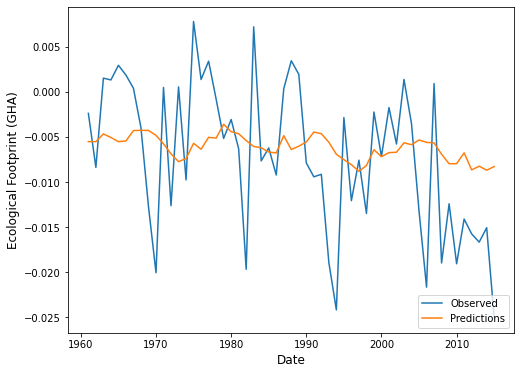

In [69]:
# Plot the original and predicted CO2 emissions set
import pandas as pd
pd.options.mode.chained_assignment = None 
train = residual_es[:]
valid = residual_es[:]
valid['Predictions'] = predicted_resid
plt.figure(figsize=(8,6))
#plt.title('Forecasting Per Capita CO2 Emissions')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Ecological Footprint (GHA)', fontsize=12)
plt.plot(train['residuals'])
plt.plot(valid['Predictions'])
plt.legend(['Observed', 'Predictions'], loc='lower right')
plt.show()

In [72]:
ES_Result['fit_resid'] = predicted_resid
ES_Result

Hybrid_Result =  pd.DataFrame(columns=['raw', 'predicted', 'fit_resid'])
Hybrid_Result['raw'] = df_India['total'][:'2015-01-01']
Hybrid_Result['predicted'] = preds
Hybrid_Result['fit_resid'] = predicted_resid
Hybrid_Result['Hybrib_pred'] = Hybrid_Result['predicted'] + Hybrid_Result['fit_resid']
Hybrid_Result.dropna()

,raw,predicted,fit_resid,Hybrib_pred
year,,,,
1961-01-01,0.625609,0.627998,-0.005525,0.622473
1962-01-01,0.629613,0.637989,-0.005528,0.632461
1963-01-01,0.627844,0.626325,-0.004668,0.621658
1964-01-01,0.622689,0.621370,-0.005062,0.616308
1965-01-01,0.613171,0.610227,-0.005525,0.604702
1966-01-01,0.619166,0.617306,-0.005450,0.611856
1967-01-01,0.643092,0.642696,-0.004299,0.638397
1968-01-01,0.652200,0.656185,-0.004266,0.651919
1969-01-01,0.653963,0.666694,-0.004288,0.662406


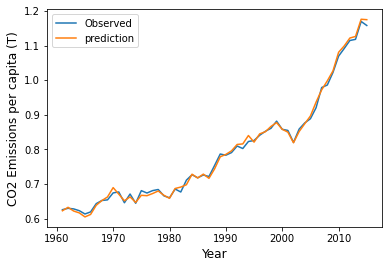

In [73]:
# %% plot on training dataset

plt.plot(Hybrid_Result['raw'],  label='Observed')
plt.plot(Hybrid_Result['Hybrib_pred'], label='prediction')
plt.xlabel('Year', size=12)
plt.ylabel('CO2 Emissions per capita (T)', size=12)
plt.legend()
plt.show()

***Evaluate***

In [74]:
# Evaluate mse
rmse = np.sqrt(mean_squared_error(Hybrid_Result['raw'],Hybrid_Result['Hybrib_pred']))
print("Root Mean Absoulute Error is:", round(rmse,3))
print("")

# Determine the Mean Absoulute Error
mae = mean_absolute_error(Hybrid_Result['raw'],Hybrid_Result['Hybrib_pred'])
print("The Mean Absoulte Error is:", round(mae,3))
print("")

#Creare a function to calculate MAPE for our models
def MAPE(pred): 
    return np.mean(np.abs((Hybrid_Result['raw'] - pred) / Hybrid_Result['raw'])) * 100
print('Mean Absolute Percentage Error is:', round(MAPE(Hybrid_Result['Hybrib_pred']),3))
print("")

Root Mean Absoulute Error is: 0.008

The Mean Absoulte Error is: 0.007

Mean Absolute Percentage Error is: 0.835



***Export predicted Data in csv***

In [75]:
Hybrid_Result.to_csv("../Data/EFHybridPredictions.csv")